In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import simpy
import scipy.stats as st
import os
import math
import heapq
from scipy import stats
from scipy.stats import t, sem

In [2]:
SAVE_DIR = 'media'
os.makedirs(SAVE_DIR, exist_ok=True)
RANDOM_SEED = 42

# Defaults
N_SIM = 100
N_CUSTOMERS = 200
ARRIVAL_INTERVAL = 10.0
SERVICE_TIME = 12.0

### 1.
Using the Erlang C Formula (A. Willig, 1999), which calculates the probability of queuing we find the following:

#### M/M/2 Queue:

1. **Erlang C Formula**: 
   $$ P_w = \frac{\frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}}{\sum_{k=0}^{1} \frac{(\rho \cdot 2)^k}{k!} + \frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}} $$

2. **Average Waiting Time in Queue**:
   $$ W_q = \frac{P_w}{2\mu - \lambda} $$

3. **Total Average Time in System**:
   $$ W = W_q + \frac{1}{\mu} $$

#### M/M/1 Queue:

1. **Average Waiting Time in Queue**:
   $$ \rho' = \frac{\lambda'}{\mu} = \frac{\rho}{2} $$
   $$ W_q' = \frac{1}{\mu - \lambda'} $$

2. **Total Average Time in System**:
   $$ W' = W_q' + \frac{1}{\mu} $$

It makes sense that the queue time in a M/M/N system where $N>2$ has shorter queue times. Non-mathematically this can be thought as two supermarkets where one supermarket only has one cashier (N=1) available in comparison to the other supermarket that has two cashiers (N=2). Assuming same parameters, the supermarket with two cashiers will have higher throughput.

In [3]:
def erlangC(n, rho):
    """
    Calculate the Erlang C formula for a given number of servers and system load.

    The Erlang C formula is used in queue theory to determine the probability 
    that an arriving customer has to wait for service in an M/M/n queue.

    Parameters:
    n (int): The number of servers in the system.
    rho (float): The system load

    Returns:
    float: The probability of having to wait for service in the queue.
    """
    numerator = (rho**n / math.factorial(n)) * (1 / (1 - rho))
    denominator = sum([(rho**k) / math.factorial(k) for k in range(n)]) + numerator
    return numerator / denominator

def mxn_queue(lambda_rate, mu, n):
    """
    This function computes the average waiting time in the queue for a multi-server queue model.

    Parameters:
    lambda_rate (float): The arrival rate into the system.
    mu (float): The service rate of each individual server.
    n (int): The number of servers in the queue system.

    Returns:
    A float containing the average waiting time in the queue (Wq).
    """
    rho = lambda_rate / (n * mu) 
    Pw = erlangC(n, rho)
    Wq = Pw / (n * mu - lambda_rate) 
    return Wq

def mx1_queue(lambda_rate, mu, n):
    """
    This function computes the average waiting time in the queue for a single-server queue model.
    The arrival rate is adjusted to compare with an M/M/n queue.

    Parameters:
    lambda_rate (float): The total arrival rate into the system, to be adjusted for single-server comparison.
    mu (float): The service rate of the single server.
    n (int): The number of servers in the M/M/n system for comparison.

    Returns:
    A float containing the average waiting time in the queue (Wq').
    """
    adjusted_lambda = lambda_rate / n  # Adjusted for comparison with M/M/n
    rho = adjusted_lambda / mu
    Wq_prime = 1 / (mu - adjusted_lambda)
    return Wq_prime


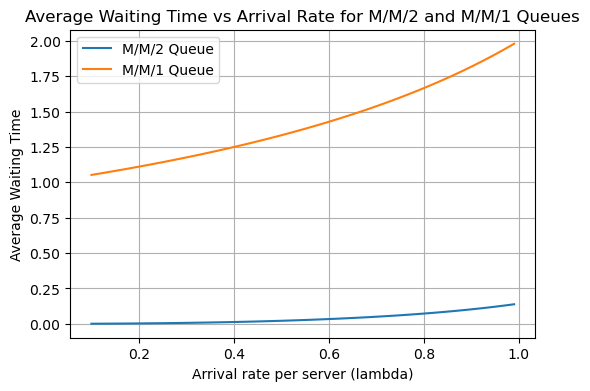

In [4]:
# Parameters
mu = 1
n = 2
lambda_rates = np.linspace(0.1, mu-0.01, 100)  # Vary lambda such that rho < 1 at all times

# Calculate waiting times for each value of lambda
waiting_times_mmn = [mxn_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]
waiting_times_mm1 = [mx1_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(lambda_rates, waiting_times_mmn, label='M/M/2 Queue')
plt.plot(lambda_rates, waiting_times_mm1, label='M/M/1 Queue')
plt.xlabel('Arrival rate per server (lambda)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Arrival Rate for M/M/2 and M/M/1 Queues')
plt.legend()
plt.grid(True)
plt.show()

### 2.
Using https://simpy.readthedocs.io/en/latest/examples/bank_renege.html tutorial code as base

In [5]:
def source(env, cst_total, arrival_interval, counters, store_wait_times, arrival_pdf='exp', service_pdf='exp', service_time=SERVICE_TIME):
    """
    Generates customers at random intervals and initiates their service process.

    Parameters:
    env (simpy.Environment): The simulation environment.
    number (int): The total number of customers to generate.
    interval (float): The average interval time between customer arrivals.
    counter (simpy.Resource): The service counter/resource being used by customers.
    wait_times (list): A list to record the wait times of each customer.
    dist_src (str): The type of distribution for source intervals ('exp' for exponential, 'const' for constant).

    Raises:
    ValueError: If an invalid distribution type is provided.
    """
    for i in range(cst_total):
        c = customer(env, f'Customer{i:02d}', counters, store_wait_times, service_pdf=service_pdf, service_time=service_time)
        env.process(c)
        if arrival_pdf == 'exp':
            t = random.expovariate(1.0 / arrival_interval)
        elif arrival_pdf == 'const':
            t = arrival_interval
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(t)

def customer(env, name, counters, store_wait_times, service_pdf='exp', service_time=SERVICE_TIME, hyperexp_p=0.25, hyperexp_factor=5):
    """
    Represents a customer arriving, being served, and leaving.

    This function models the behavior of a customer in the queue. It records the waiting time
    and the service time, depending on the specified distribution type for service.

    Parameters:
    env (simpy.Environment): The simulation environment.
    name (str): The name of the customer.
    counter (simpy.Resource): The service counter/resource being used.
    wait_times (list): A list to record the wait time of this customer.
    dist (str): The type of distribution for service time ('exp', 'const', or 'hyperexp').

    Constants:
    SERVICE_TIME (float): The average service time, used in service time calculations. 

    Raises:
    ValueError: If an invalid distribution type is provided for service time.
    """
    arrive = env.now
    with counters.request() as req:
        results = yield req 
        wait = env.now - arrive
        if service_pdf == 'exp':
            service_time = random.expovariate(1.0 / service_time) 
        elif service_pdf == 'const':
            service_time = 12.0
        elif service_pdf == 'hyperexp':
            r = random.random()
            if r < (1-hyperexp_p):
                service_time = random.expovariate(1.0 / service_time)
            else:
                service_time = random.expovariate(1.0 / (hyperexp_factor * service_time))
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(service_time)
        store_wait_times.append(wait)

def simulate_experiments(dist_src='exp', dist_cst='exp', ns=[1, 2, 4], n_sim=N_SIM):
    """Run the simulations with provided parameters and return the waiting times and their averages"""
    wait_times_data = {n: [[] for _ in range(n_sim)] for n in ns}
    wait_times_data_mean = {n: [] for n in ns}
    for n in ns:
        for i in range(n_sim):
            random.seed(RANDOM_SEED+i)
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counter, wait_times, arrival_pdf=dist_src, service_pdf=dist_cst))
            env.run()
            wait_times_data[n][i] = wait_times
            wait_times_data_mean[n].append(np.mean(wait_times))
    return wait_times_data, wait_times_data_mean

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, mean waiting time: {avg_wait_time:.2f}, std dev: {std_dev:.2f}, 95% CI ({c_low:.2e} | {c_high:.2e})')
    return avgs, stds, conf_intervals

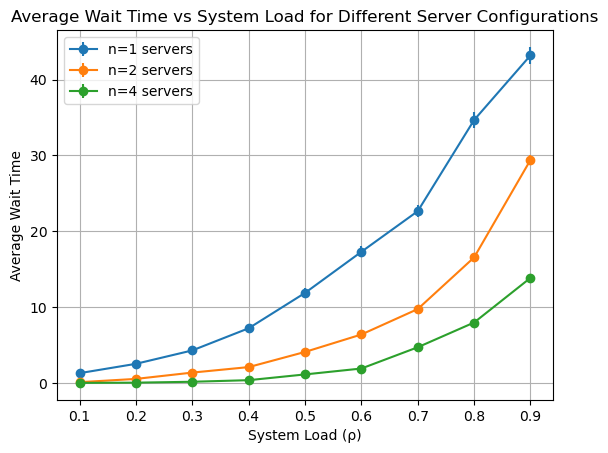

In [6]:
def run_simulation(num_servers, rho_values, mu, simulation_time, num_simulations):
    """Run the queue simulation for different values of system load (ρ)."""
    results = []
    for rho in rho_values:
        lambda_rate = rho * num_servers * mu  
        wait_times_aggregate = []
        for _ in range(num_simulations):
            env = simpy.Environment()
            wait_times = []
            env.process(source(env, N_CUSTOMERS, 1/lambda_rate, simpy.Resource(env, capacity=num_servers), wait_times))
            env.run(until=simulation_time)
            wait_times_aggregate.extend(wait_times)
        avg_wait = np.mean(wait_times_aggregate)
        std_dev = np.std(wait_times_aggregate)
        conf_interval = st.t.interval(0.95, len(wait_times_aggregate)-1, loc=avg_wait, scale=st.sem(wait_times_aggregate))
        results.append((rho, avg_wait, std_dev, conf_interval))
    return results

# Set parameters
MU = 1 / SERVICE_TIME
rho_values = np.linspace(0.1, 0.9, 9)  # Varying ρ from 0.1 to 0.9
simulation_time = 1000
num_simulations = 100  

# Run simulations for different server numbers
for num_servers in [1, 2, 4]:
    simulation_results = run_simulation(num_servers, rho_values, MU, simulation_time, num_simulations)
    # Plotting
    avg_wait_times = [result[1] for result in simulation_results]
    conf_intervals = [result[3] for result in simulation_results]
    errors = [(upper - lower) / 2 for lower, upper in conf_intervals]
    plt.errorbar(rho_values, avg_wait_times, yerr=errors, label=f'n={num_servers} servers', fmt='-o')

plt.xlabel('System Load (ρ)')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs System Load for Different Server Configurations')
plt.legend()
plt.grid(True)
plt.show()


Servers: 1, Average Waiting Time: 223.04, Std Dev: 67.76, 95% CI: lower 2.10e+02 | upper 2.37e+02
Servers: 2, Average Waiting Time: 3.59, Std Dev: 1.23, 95% CI: lower 3.34e+00 | upper 3.83e+00
Servers: 3, Average Waiting Time: 0.57, Std Dev: 0.25, 95% CI: lower 5.24e-01 | upper 6.25e-01
Servers: 4, Average Waiting Time: 0.11, Std Dev: 0.09, 95% CI: lower 9.21e-02 | upper 1.26e-01
Servers: 5, Average Waiting Time: 0.02, Std Dev: 0.03, 95% CI: lower 1.57e-02 | upper 2.94e-02


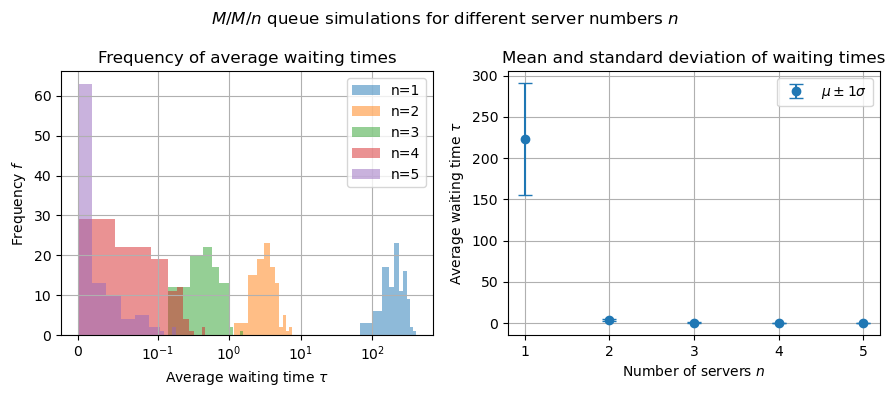

In [7]:
def simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1, 2, 4]):
    """Run the simulations with provided parameters and return the average waiting times"""
    wait_times_data = {n: [] for n in ns}
    for n in ns:
        for i in range(N_SIM):
            random.seed(RANDOM_SEED+i) # Same seed for reproducibility
            env = simpy.Environment()
            counters = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counters, wait_times, arrival_pdf=arrival_pdf, service_pdf=service_pdf, service_time=SERVICE_TIME))
            env.run()
            wait_times_data[n].append(np.mean(wait_times))
    return wait_times_data

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, Average Waiting Time: {avg_wait_time:.2f}, Std Dev: {std_dev:.2f}, 95% CI: lower {c_low:.2e} | upper {c_high:.2e}')
    return avgs, stds, conf_intervals

def plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title):
    plt.figure(figsize=(9, 4), layout='tight')
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    for num_servers, times in wait_times_data.items():
        plt.hist(times, label=f'n={num_servers}', alpha=0.5)
    plt.xlabel('Average waiting time $\\tau$')
    plt.xscale('symlog', linthresh=0.1)
    plt.ylabel('Frequency $f$')
    plt.title('Frequency of average waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.errorbar(ns, avgs, yerr=stds, fmt='o', capsize=5, label='$\\mu \\pm 1\\sigma$')
    plt.xlabel('Number of servers $n$')
    plt.ylabel('Average waiting time $\\tau$')
    plt.title('Mean and standard deviation of waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    # plt.savefig(f'{SAVE_DIR}/{title.replace(' ', '_').replace('/', '-')}.png')
    plt.show()

# Experiment
ns = np.arange(1, 6, 1, dtype=int)
wait_times_data = simulate_experiments(arrival_pdf='exp', service_pdf='const', ns=ns)
avgs, stds, conf_intervals = get_statistics(wait_times_data)

plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title='$M/M/n$ queue simulations for different server numbers $n$')

Servers: 1, Average Waiting Time: 1410.28, Std Dev: 302.56, 95% CI: lower 1.35e+03 | upper 1.47e+03
Servers: 2, Average Waiting Time: 268.17, Std Dev: 129.41, 95% CI: lower 2.42e+02 | upper 2.94e+02
Servers: 3, Average Waiting Time: 31.20, Std Dev: 25.93, 95% CI: lower 2.60e+01 | upper 3.64e+01
Servers: 4, Average Waiting Time: 5.80, Std Dev: 5.44, 95% CI: lower 4.72e+00 | upper 6.89e+00
Servers: 5, Average Waiting Time: 1.50, Std Dev: 1.51, 95% CI: lower 1.20e+00 | upper 1.80e+00


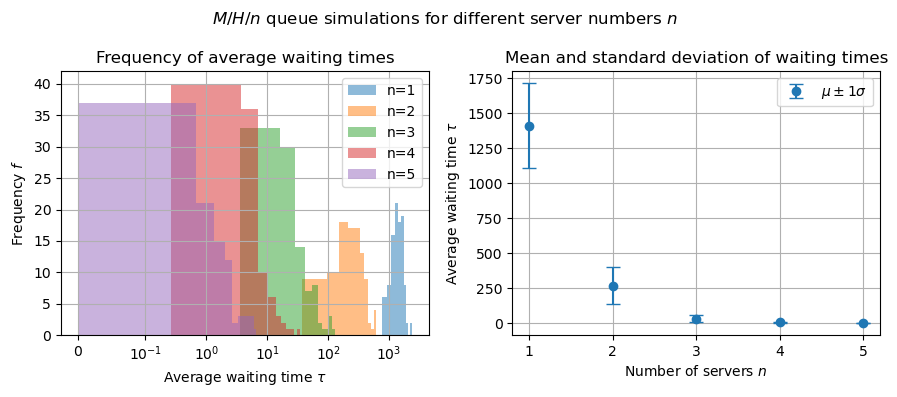

In [8]:
# Experiment
wait_times_data = simulate_experiments(arrival_pdf='exp', service_pdf='hyperexp', ns=ns)
avgs, stds, conf_intervals = get_statistics(wait_times_data)

plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title='$M/H/n$ queue simulations for different server numbers $n$')

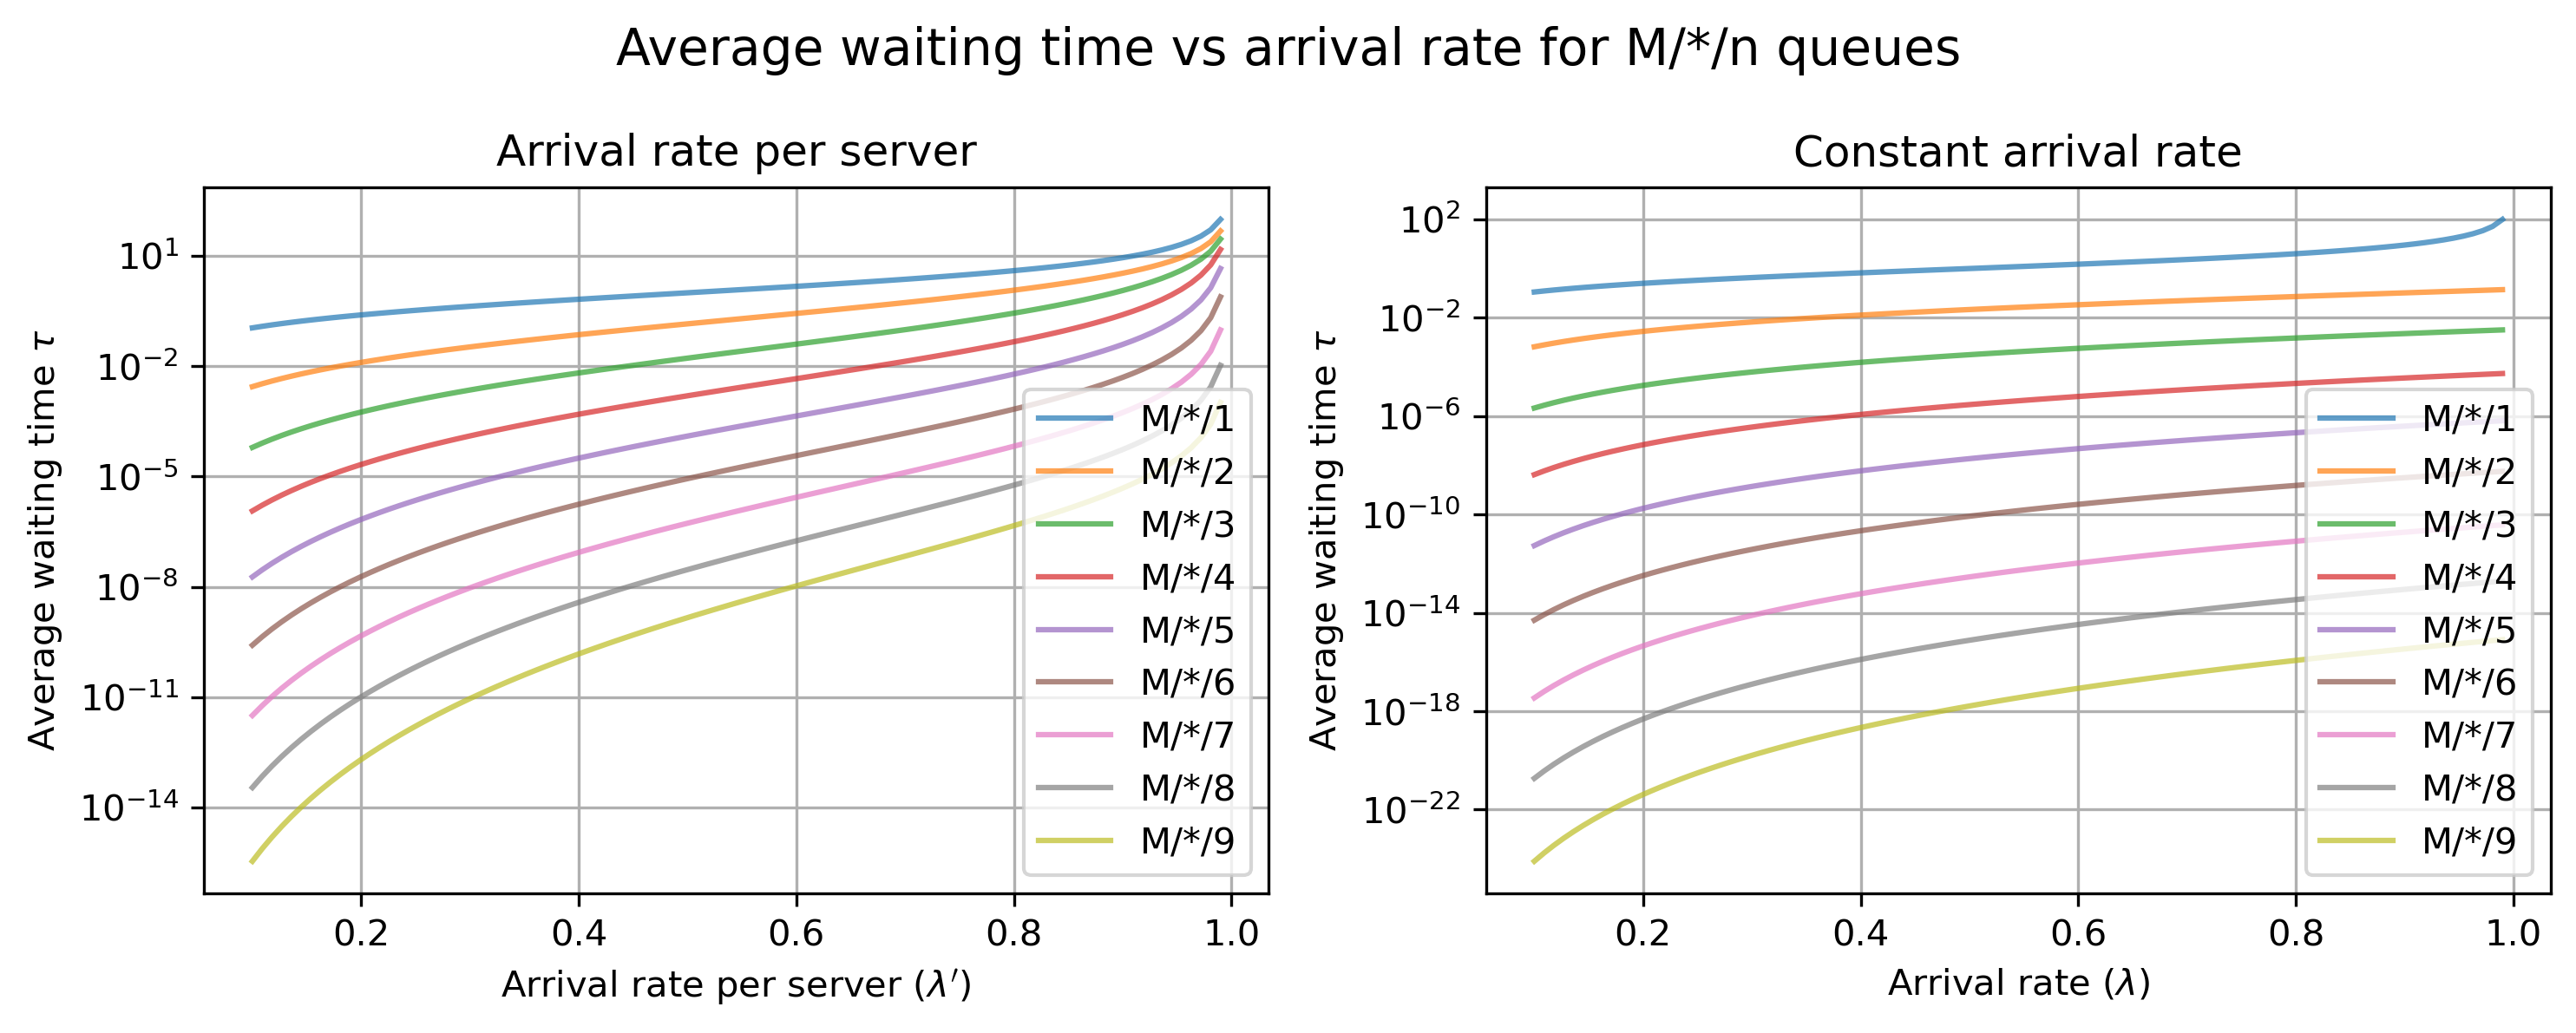

In [12]:
ns = np.arange(1, 10, dtype=int)
# Calculate waiting times for each value of lambda
waiting_times_mxns_pserv = {n: [] for n in ns}
waiting_times_mxns = {n: [] for n in ns}
for n in ns:
    waiting_times_mxns_pserv[n] = [mxn_queue(lambda_rate*n, mu, n) for lambda_rate in lambda_rates]
    waiting_times_mxns[n] = [mxn_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]
waiting_times_mx1 = [mx1_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(10, 4), dpi=300, layout='tight')
plt.suptitle('Average waiting time vs arrival rate for M/*/n queues', fontsize=14)
plt.subplot(1, 2, 1)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns_pserv[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate per server ($\\lambda\'$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Arrival rate per server')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate ($\\lambda$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Constant arrival rate')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
class SJFPriorityResource(simpy.PriorityResource):
    def _do_put(self, event):
        heapq.heappush(self.queue, (event.priority, next(self._put_counters), event)) # type: ignore

def customer(env, name, counter, service_time, wait_times, priority):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    if priority:
        with counter.request(priority=service_time) as req:  # Use service time as priority
            yield req
            wait = env.now - arrive
            yield env.timeout(service_time)
            wait_times.append(wait)
    else:
        with counter.request() as req:  # No priority
            yield req
            wait = env.now - arrive
            yield env.timeout(service_time)
            wait_times.append(wait)

def source(env, number, interval, counter, wait_times, priority):
    for i in range(number):
        service_time = random.expovariate(1.0 / SERVICE_TIME)
        c = customer(env, f'Customer{i:03d}', counter, service_time, wait_times, priority)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)

def run_simulation(num_servers, priority):
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    if priority:
        # Use SimPy's PriorityResource directly
        counter = simpy.PriorityResource(env, capacity=num_servers)
    else:
        counter = simpy.Resource(env, capacity=num_servers)
    wait_times = []
    env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counter, wait_times, priority))
    env.run()
    return wait_times

# Run simulations for FIFO and SJF scheduling
print('Running FIFO simulation...')
wait_times_fifo = run_simulation(1, priority=False)
print(f'FIFO Average Wait Time: {np.mean(wait_times_fifo):.2f}, Std Dev: {np.std(wait_times_fifo):.2f}, 95% CI: {t.interval(0.95, len(wait_times_fifo)-1, loc=np.mean(wait_times_fifo), scale=sem(wait_times_fifo))}')

print('Running SJF simulation...')
wait_times_sjf = run_simulation(1, priority=True)
print(f'SJF Average Wait Time: {np.mean(wait_times_sjf):.2f}, Std Dev: {np.std(wait_times_sjf):.2f}, 95% CI: {t.interval(0.95, len(wait_times_sjf)-1, loc=np.mean(wait_times_sjf), scale=sem(wait_times_sjf))}')

Running FIFO simulation...
FIFO Average Wait Time: 376.78, Std Dev: 167.22, 95% CI: (353.40907457119334, 400.15879141648014)
Running SJF simulation...
SJF Average Wait Time: 97.49, Std Dev: 308.59, 95% CI: (54.35396384171101, 140.6272602165355)


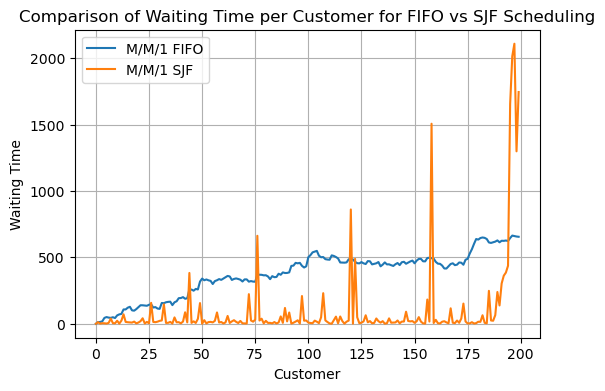

In [14]:
# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(wait_times_fifo, label='M/M/1 FIFO')
plt.plot(wait_times_sjf, label='M/M/1 SJF')
plt.xlabel('Customer')
plt.ylabel('Waiting Time')
plt.title('Comparison of Waiting Time per Customer for FIFO vs SJF Scheduling')
plt.legend()
plt.grid(True)
plt.show()

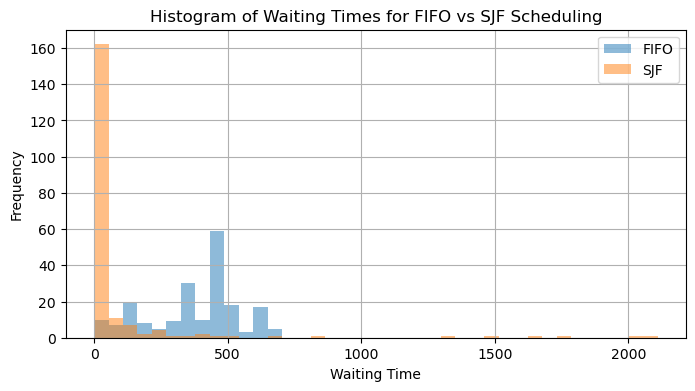

In [15]:
# Histogram settings
bins = np.linspace(0, max(max(wait_times_fifo), max(wait_times_sjf)), 40)

plt.figure(figsize=(8, 4))

# FIFO Histogram
plt.hist(wait_times_fifo, bins, alpha=0.5, label='FIFO')

# SJF Histogram
plt.hist(wait_times_sjf, bins, alpha=0.5, label='SJF')

plt.xlabel('Waiting Time')
plt.ylabel('Frequency')
plt.title('Histogram of Waiting Times for FIFO vs SJF Scheduling')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
rs = []
for i in range(1000):
    rs.append(random.expovariate(1/(SERVICE_TIME*5))) 
print(np.mean(rs))
